In [1]:
import scanpy as sc
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scvi
import torch
import warnings
warnings.simplefilter("ignore", FutureWarning)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)


In [2]:
adata = sc.read('annotated.h5ad')
adata

AnnData object with n_obs × n_vars = 58015 × 14469
    obs: 'samples', 'condition', 'location', 'n_genes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'pct_counts_mt', 'pct_counts_ribo', 'pct_counts_hb', 'low_label', 'low_score', '_scvi_batch', '_scvi_labels', 'overcluster', 'low_major', 'Cell_Type'
    var: 'n_cells'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'log1p', 'low_major_colors', 'neighbors', 'overcluster', 'rank_genes_groups', 'umap'
    obsm: 'X_scVI', 'X_umap', '_scvi_extra_categorical_covs', '_scvi_extra_continuous_covs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [3]:
# let's take a look at abundances of different cell types
adata.obs["Cell_Type"].value_counts()

Cell_Type
CD4+ T Cells                    17357
B Cells                         10774
CD8+ T cells                     6676
Regulatory T Cells               3907
CMS3                             3876
Helper 17 T cells                2377
Dendritic cells                  2105
CMS2                             1792
Spp1+                            1634
Follicular helper T cells        1486
Gamma delta T cells              1336
NK cells                         1320
Stromal 2                         897
Mast cells                        642
Tip-like ECs                      610
Pericytes                         457
Mature Enterocytes type 2         326
Plasma Cells                      240
Plasmacytoid Dendritic Cells       89
Stromal 3                          65
Enteric glia cells                 49
Name: count, dtype: int64

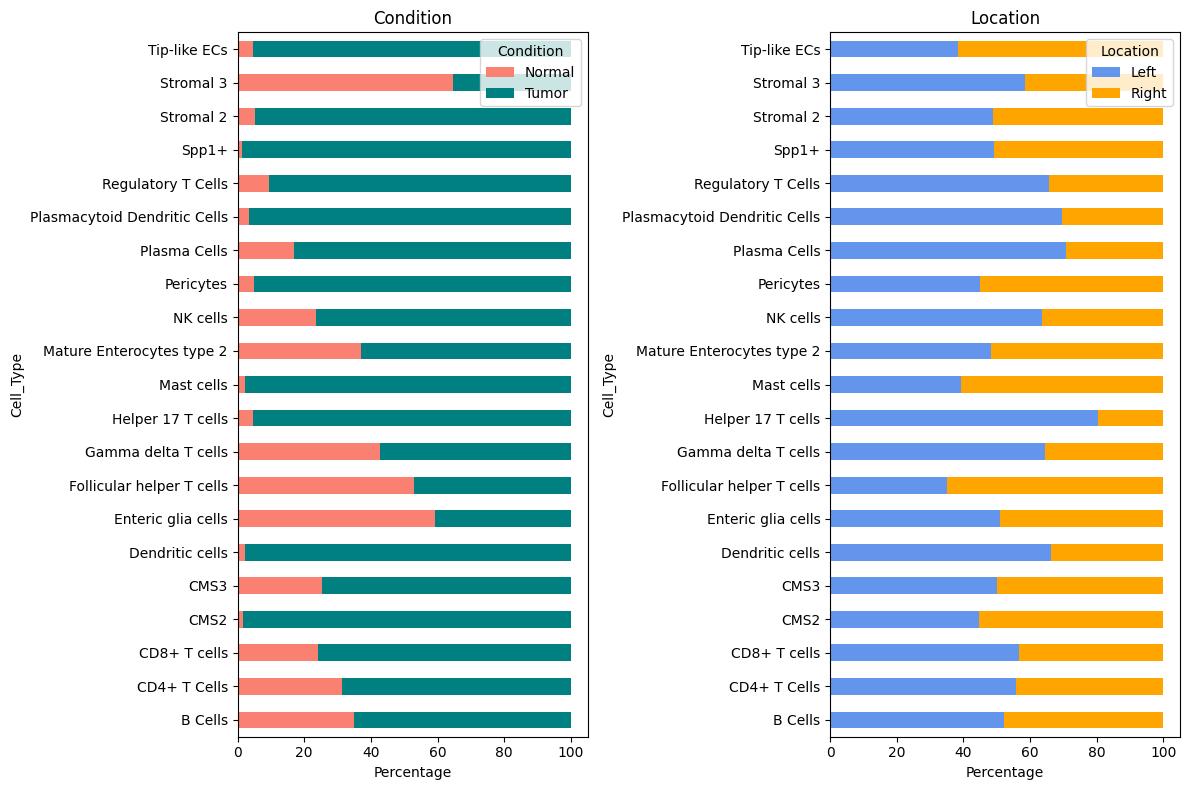

In [4]:
# For Condition
condition_counts = pd.crosstab(adata.obs['Cell_Type'], 
                                adata.obs['condition'], 
                                normalize='index') * 100

# For Location
location_counts = pd.crosstab(adata.obs['Cell_Type'], 
                               adata.obs['location'], 
                               normalize='index') * 100

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))

condition_counts.plot(kind='barh', stacked=True, ax=ax1, 
                      color=['salmon', 'teal'])
ax1.set_title('Condition')
ax1.set_xlabel('Percentage')
ax1.legend(title='Condition')

location_counts.plot(kind='barh', stacked=True, ax=ax2,
                     color=['cornflowerblue', 'orange'])
ax2.set_title('Location')
ax2.set_xlabel('Percentage')
ax2.legend(title='Location')

plt.tight_layout()
plt.show()

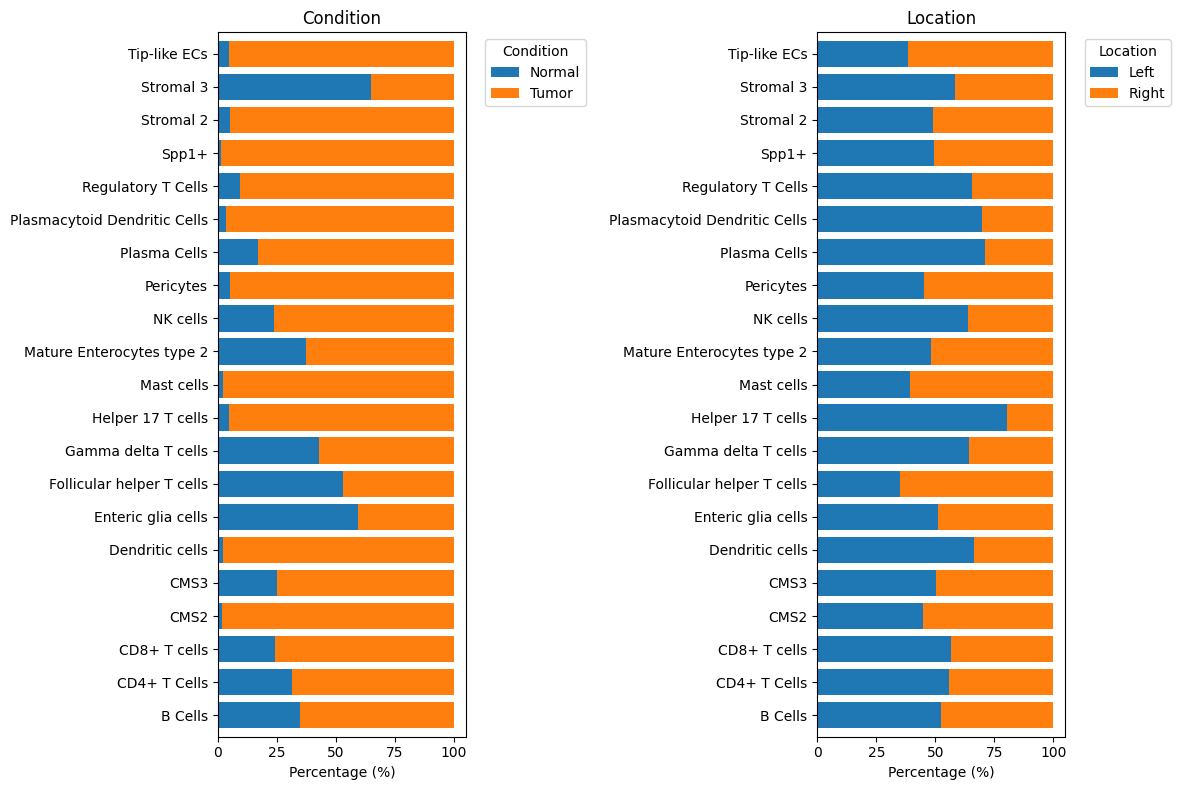

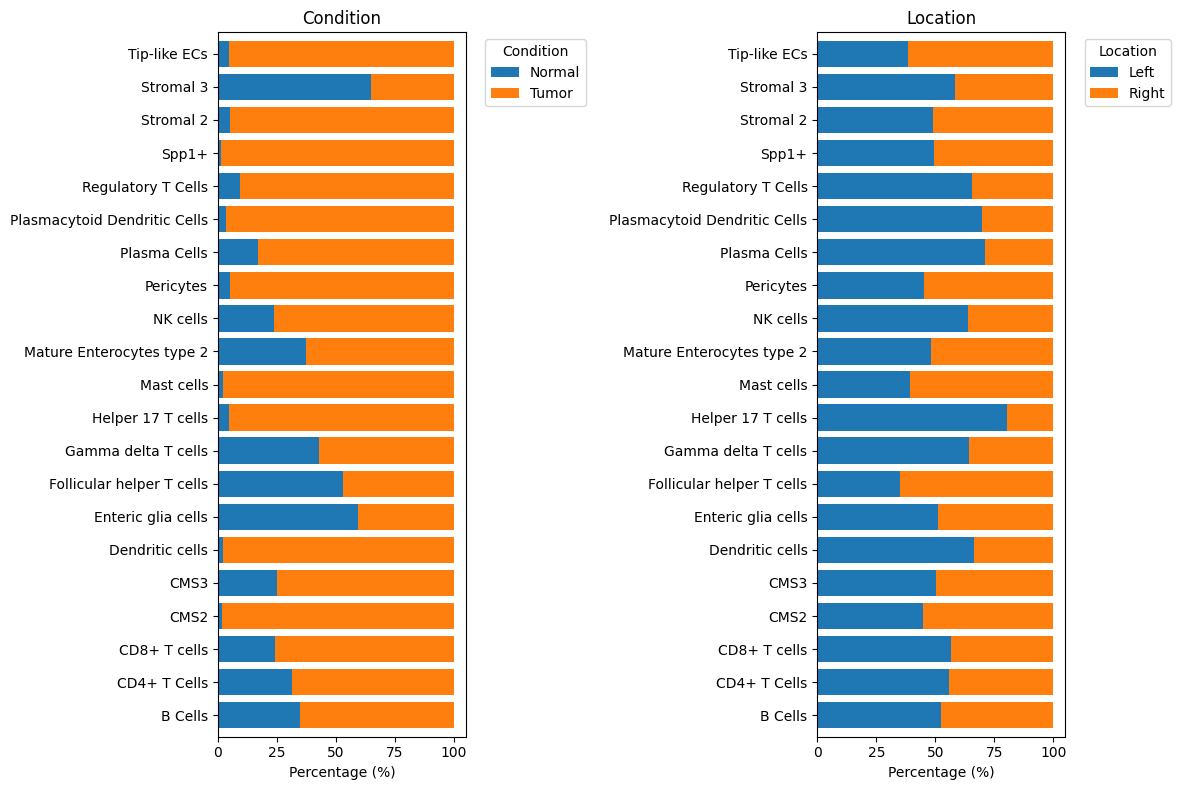

In [5]:
def plot_metadata_distribution(adata, groupby, metadata_cols, figsize=(12, 8)):
    """
    Plot stacked bar charts showing distribution of metadata across groups
    
    Parameters:
    -----------
    adata : AnnData object
    groupby : str - column to group by (e.g., 'cell_type')
    metadata_cols : list - metadata columns to visualize (e.g., ['condition', 'location'])
    """
    
    n_plots = len(metadata_cols)
    fig, axes = plt.subplots(1, n_plots, figsize=figsize)
    
    if n_plots == 1:
        axes = [axes]
    
    for i, col in enumerate(metadata_cols):
        # Calculate proportions
        props = pd.crosstab(adata.obs[groupby], 
                           adata.obs[col], 
                           normalize='index') * 100
        
        # Plot
        props.plot(kind='barh', stacked=True, ax=axes[i], 
                   width=0.8, legend=True)
        axes[i].set_title(col.title())
        axes[i].set_xlabel('Percentage (%)')
        axes[i].set_ylabel('')
        axes[i].legend(title=col.title(), bbox_to_anchor=(1.05, 1))
    
    plt.tight_layout()
    return fig

# Use it
plot_metadata_distribution(adata, 
                          groupby='Cell_Type', 
                          metadata_cols=['condition', 'location'])

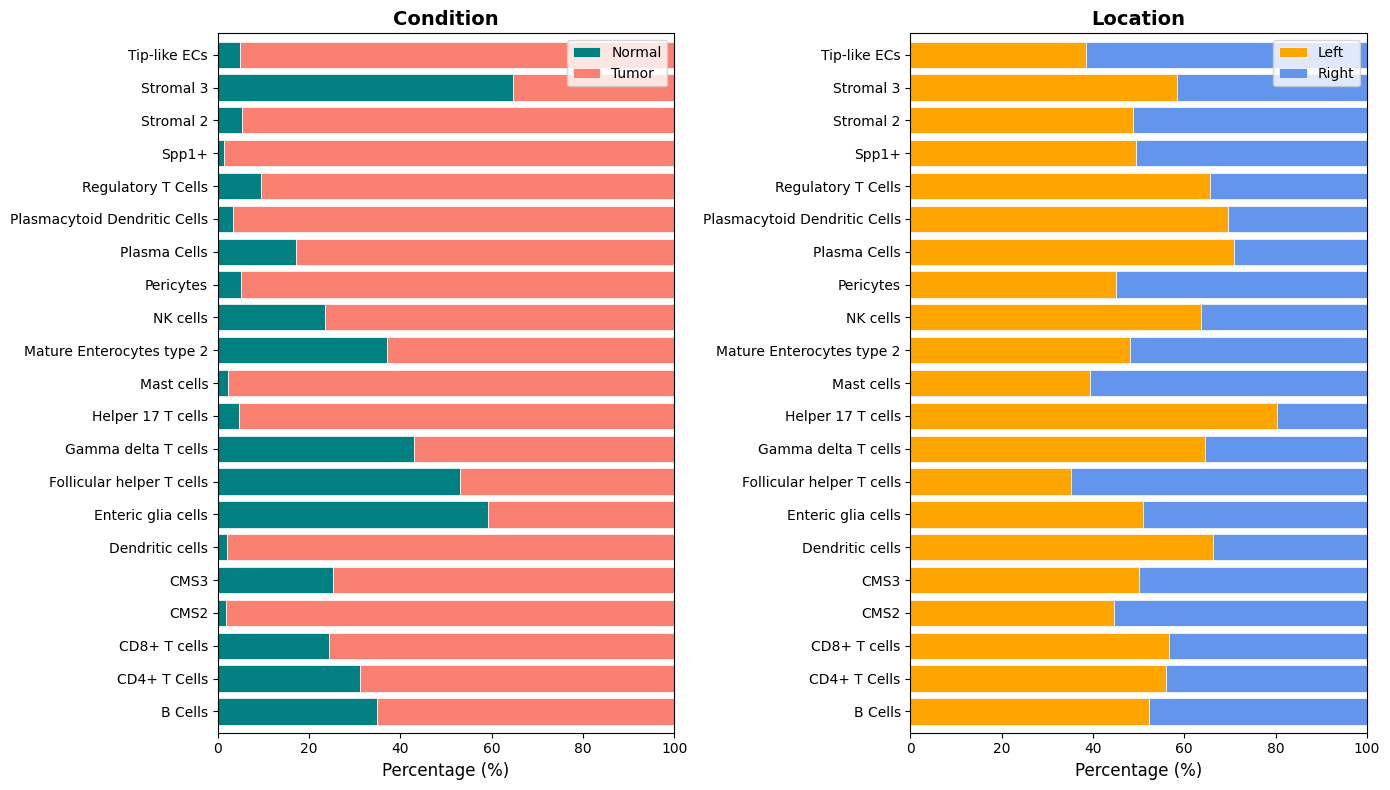

In [6]:
def plot_sample_composition(adata, groupby='Cell_Type', 
                           condition_col='condition',
                           location_col='location',
                           condition_colors={'Tumor': 'salmon', 'Normal': 'teal'},
                           location_colors={'Right': 'cornflowerblue', 'Left': 'orange'}):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
    
    # Condition plot
    condition_props = pd.crosstab(adata.obs[groupby], 
                                  adata.obs[condition_col], 
                                  normalize='index') * 100
    
    condition_props.plot(kind='barh', stacked=True, ax=ax1,
                        color=[condition_colors.get(c, 'gray') 
                              for c in condition_props.columns],
                        width=0.8, edgecolor='white', linewidth=0.5)
    ax1.set_title('Condition', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Percentage (%)', fontsize=12)
    ax1.set_ylabel('')
    ax1.legend(title='', fontsize=10)
    ax1.set_xlim(0, 100)
    
    # Location plot
    location_props = pd.crosstab(adata.obs[groupby], 
                                 adata.obs[location_col], 
                                 normalize='index') * 100
    
    location_props.plot(kind='barh', stacked=True, ax=ax2,
                       color=[location_colors.get(c, 'gray') 
                             for c in location_props.columns],
                       width=0.8, edgecolor='white', linewidth=0.5)
    ax2.set_title('Location', fontsize=14, fontweight='bold')
    ax2.set_xlabel('Percentage (%)', fontsize=12)
    ax2.set_ylabel('')
    ax2.legend(title='', fontsize=10)
    ax2.set_xlim(0, 100)
    
    plt.tight_layout()
    return fig

# Use it
plot_sample_composition(adata)
plt.savefig('sample_composition.pdf', bbox_inches='tight', dpi=300)


In [7]:
# Example: Get composition for a specific cluster (like C13 - Mast cells)
def analyze_specific_cluster(adata, cluster_name, celltype_col='Cell_Type',
                             location_col='location', condition_col='condition'):
    """
    Analyze composition of a specific cell type/cluster
    """
    # Filter to specific cluster
    cluster_cells = adata[adata.obs[celltype_col] == cluster_name]
    total_cells = len(cluster_cells)
    
    print(f"\n{cluster_name}")
    print(f"Total cells: {total_cells:,}")
    print("\nBy Location:")
    
    for loc in cluster_cells.obs[location_col].unique():
        loc_cells = cluster_cells[cluster_cells.obs[location_col] == loc]
        n_cells = len(loc_cells)
        pct = (n_cells / total_cells) * 100
        print(f"  {loc}: {n_cells:,} cells ({pct:.1f}%)")
    
    print("\nBy Condition:")
    for cond in cluster_cells.obs[condition_col].unique():
        cond_cells = cluster_cells[cluster_cells.obs[condition_col] == cond]
        n_cells = len(cond_cells)
        pct = (n_cells / total_cells) * 100
        print(f"  {cond}: {n_cells:,} cells ({pct:.1f}%)")
    
    print("\nBy Location × Condition:")
    crosstab = pd.crosstab(cluster_cells.obs[location_col], 
                          cluster_cells.obs[condition_col])
    print(crosstab)
    print("\nPercentages:")
    print((crosstab / total_cells * 100).round(1))

# Example usage
analyze_specific_cluster(adata, 'Mast cells')


Mast cells
Total cells: 642

By Location:
  Right: 390 cells (60.7%)
  Left: 252 cells (39.3%)

By Condition:
  Tumor: 628 cells (97.8%)
  Normal: 14 cells (2.2%)

By Location × Condition:
condition  Normal  Tumor
location                
Left           11    241
Right           3    387

Percentages:
condition  Normal  Tumor
location                
Left          1.7   37.5
Right         0.5   60.3


In [8]:
# Example: Get composition for a specific cluster (like C13 - Mast cells)
def analyze_specific_cluster(adata, cluster_name, celltype_col='Cell_Type',
                             location_col='location', condition_col='condition'):
    """
    Analyze composition of a specific cell type/cluster
    """
    # Filter to specific cluster
    cluster_cells = adata[adata.obs[celltype_col] == cluster_name]
    total_cells = len(cluster_cells)
    
    print(f"\n{cluster_name}")
    print(f"Total cells: {total_cells:,}")
    print("\nBy Location:")
    
    for loc in cluster_cells.obs[location_col].unique():
        loc_cells = cluster_cells[cluster_cells.obs[location_col] == loc]
        n_cells = len(loc_cells)
        pct = (n_cells / total_cells) * 100
        print(f"  {loc}: {n_cells:,} cells ({pct:.1f}%)")
    
    print("\nBy Condition:")
    for cond in cluster_cells.obs[condition_col].unique():
        cond_cells = cluster_cells[cluster_cells.obs[condition_col] == cond]
        n_cells = len(cond_cells)
        pct = (n_cells / total_cells) * 100
        print(f"  {cond}: {n_cells:,} cells ({pct:.1f}%)")
    
    print("\nBy Location × Condition:")
    crosstab = pd.crosstab(cluster_cells.obs[location_col], 
                          cluster_cells.obs[condition_col])
    print(crosstab)
    print("\nPercentages:")
    print((crosstab / total_cells * 100).round(1))

# Example usage
analyze_specific_cluster(adata, 'Mast cells')


Mast cells
Total cells: 642

By Location:
  Right: 390 cells (60.7%)
  Left: 252 cells (39.3%)

By Condition:
  Tumor: 628 cells (97.8%)
  Normal: 14 cells (2.2%)

By Location × Condition:
condition  Normal  Tumor
location                
Left           11    241
Right           3    387

Percentages:
condition  Normal  Tumor
location                
Left          1.7   37.5
Right         0.5   60.3


In [9]:
# Summary table 1: Cell type by location
def create_summary_tables(adata, celltype_col='Cell_Type',
                         location_col='location', condition_col='condition'):
    
    # Table 1: Counts by cell type and location
    table1 = pd.crosstab(adata.obs[celltype_col], adata.obs[location_col], margins=True)
    print("\nTable 1: Cell counts by cell type and location")
    print(table1)
    
    # Table 2: Percentages by cell type and location
    table2 = pd.crosstab(adata.obs[celltype_col], adata.obs[location_col], 
                        normalize='index') * 100
    print("\nTable 2: Percentage within each cell type by location")
    print(table2.round(1))
    
    # Table 3: Counts by cell type and condition
    table3 = pd.crosstab(adata.obs[celltype_col], adata.obs[condition_col], margins=True)
    print("\nTable 3: Cell counts by cell type and condition")
    print(table3)
    
    # Table 4: Percentages by cell type and condition
    table4 = pd.crosstab(adata.obs[celltype_col], adata.obs[condition_col], 
                        normalize='index') * 100
    print("\nTable 4: Percentage within each cell type by condition")
    print(table4.round(1))
    
    # Table 5: Three-way breakdown
    table5 = adata.obs.groupby([celltype_col, location_col, condition_col]).size().unstack(fill_value=0)
    print("\nTable 5: Cell counts by cell type, location, and condition")
    print(table5)
    
    # Save all tables
    with pd.ExcelWriter('cell_composition_tables.xlsx') as writer:
        table1.to_excel(writer, sheet_name='Counts_by_location')
        table2.to_excel(writer, sheet_name='Pct_by_location')
        table3.to_excel(writer, sheet_name='Counts_by_condition')
        table4.to_excel(writer, sheet_name='Pct_by_condition')
        table5.to_excel(writer, sheet_name='Three_way_breakdown')
    
    print("\nAll tables saved to 'cell_composition_tables.xlsx'")
    
    return table1, table2, table3, table4, table5

tables = create_summary_tables(adata)


Table 1: Cell counts by cell type and location
location                       Left  Right    All
Cell_Type                                        
B Cells                        5631   5143  10774
CD4+ T Cells                   9704   7653  17357
CD8+ T cells                   3783   2893   6676
CMS2                            801    991   1792
CMS3                           1941   1935   3876
Dendritic cells                1395    710   2105
Enteric glia cells               25     24     49
Follicular helper T cells       523    963   1486
Gamma delta T cells             861    475   1336
Helper 17 T cells              1911    466   2377
Mast cells                      252    390    642
Mature Enterocytes type 2       157    169    326
NK cells                        841    479   1320
Pericytes                       206    251    457
Plasma Cells                    170     70    240
Plasmacytoid Dendritic Cells     62     27     89
Regulatory T Cells             2564   1343   3907
Sp

ModuleNotFoundError: No module named 'openpyxl'

In [10]:
create_summary_tables(adata)


Table 1: Cell counts by cell type and location
location                       Left  Right    All
Cell_Type                                        
B Cells                        5631   5143  10774
CD4+ T Cells                   9704   7653  17357
CD8+ T cells                   3783   2893   6676
CMS2                            801    991   1792
CMS3                           1941   1935   3876
Dendritic cells                1395    710   2105
Enteric glia cells               25     24     49
Follicular helper T cells       523    963   1486
Gamma delta T cells             861    475   1336
Helper 17 T cells              1911    466   2377
Mast cells                      252    390    642
Mature Enterocytes type 2       157    169    326
NK cells                        841    479   1320
Pericytes                       206    251    457
Plasma Cells                    170     70    240
Plasmacytoid Dendritic Cells     62     27     89
Regulatory T Cells             2564   1343   3907
Sp

ModuleNotFoundError: No module named 'openpyxl'

In [11]:
def create_summary_tables(adata, celltype_col='Cell_Type',
                         location_col='location', condition_col='condition',
                         save_format='both'):  # 'excel', 'csv', or 'both'
    """
    Create comprehensive summary tables with robust saving
    """
    
    # Table 1: Counts by cell type and location
    table1 = pd.crosstab(adata.obs[celltype_col], adata.obs[location_col], margins=True)
    print("\nTable 1: Cell counts by cell type and location")
    print(table1)
    
    # Table 2: Percentages by cell type and location
    table2 = pd.crosstab(adata.obs[celltype_col], adata.obs[location_col], 
                        normalize='index') * 100
    print("\nTable 2: Percentage within each cell type by location")
    print(table2.round(1))
    
    # Table 3: Counts by cell type and condition
    table3 = pd.crosstab(adata.obs[celltype_col], adata.obs[condition_col], margins=True)
    print("\nTable 3: Cell counts by cell type and condition")
    print(table3)
    
    # Table 4: Percentages by cell type and condition
    table4 = pd.crosstab(adata.obs[celltype_col], adata.obs[condition_col], 
                        normalize='index') * 100
    print("\nTable 4: Percentage within each cell type by condition")
    print(table4.round(1))
    
    # Table 5: Three-way breakdown
    table5 = adata.obs.groupby([celltype_col, location_col, condition_col]).size().unstack(fill_value=0)
    print("\nTable 5: Cell counts by cell type, location, and condition")
    print(table5)
    
    # Save tables
    try:
        if save_format in ['excel', 'both']:
            # Try saving as Excel
            try:
                with pd.ExcelWriter('cell_composition_tables.xlsx', engine='openpyxl') as writer:
                    table1.to_excel(writer, sheet_name='Counts_by_location')
                    table2.to_excel(writer, sheet_name='Pct_by_location')
                    table3.to_excel(writer, sheet_name='Counts_by_condition')
                    table4.to_excel(writer, sheet_name='Pct_by_condition')
                    table5.to_excel(writer, sheet_name='Three_way_breakdown')
                print("\n✓ Excel file saved: 'cell_composition_tables.xlsx'")
            except ImportError:
                print("\n⚠ openpyxl not installed. Install with: pip install openpyxl")
                print("Saving as CSV instead...")
                save_format = 'csv'
        
        if save_format in ['csv', 'both']:
            # Save as separate CSV files
            table1.to_csv('table1_counts_by_location.csv')
            table2.to_csv('table2_pct_by_location.csv')
            table3.to_csv('table3_counts_by_condition.csv')
            table4.to_csv('table4_pct_by_condition.csv')
            table5.to_csv('table5_three_way_breakdown.csv')
            print("\n✓ CSV files saved:")
            print("  - table1_counts_by_location.csv")
            print("  - table2_pct_by_location.csv")
            print("  - table3_counts_by_condition.csv")
            print("  - table4_pct_by_condition.csv")
            print("  - table5_three_way_breakdown.csv")
            
    except Exception as e:
        print(f"\n✗ Error saving files: {e}")
        print("Returning tables as variables instead.")
    
    return table1, table2, table3, table4, table5

# Run with CSV output (most reliable)
tables = create_summary_tables(adata, save_format='csv')


Table 1: Cell counts by cell type and location
location                       Left  Right    All
Cell_Type                                        
B Cells                        5631   5143  10774
CD4+ T Cells                   9704   7653  17357
CD8+ T cells                   3783   2893   6676
CMS2                            801    991   1792
CMS3                           1941   1935   3876
Dendritic cells                1395    710   2105
Enteric glia cells               25     24     49
Follicular helper T cells       523    963   1486
Gamma delta T cells             861    475   1336
Helper 17 T cells              1911    466   2377
Mast cells                      252    390    642
Mature Enterocytes type 2       157    169    326
NK cells                        841    479   1320
Pericytes                       206    251    457
Plasma Cells                    170     70    240
Plasmacytoid Dendritic Cells     62     27     89
Regulatory T Cells             2564   1343   3907
Sp